In [1]:
#!/usr/bin/env python3
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook
#https://towardsdatascience.com/understanding-the-seasonal-order-of-the-sarima-model-ebef613e40fa

#slice it up
df=pd.read_csv('store_1.csv',index_col=0)
df=df['total_sales']
df.index.freq="D"

#roughly 80-20 split
train=df[:'2016-09-12']
train.index.freq="D"
test=df['2016-09-13':]
test.index.freq="D"


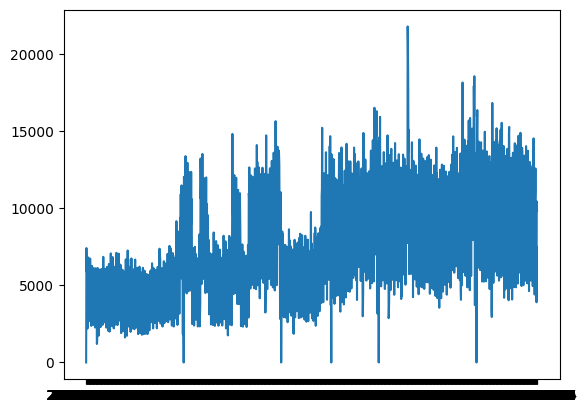

In [2]:
plt.plot(df)
plt.show()
#Wow, this looks really irregular.

/home/user/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


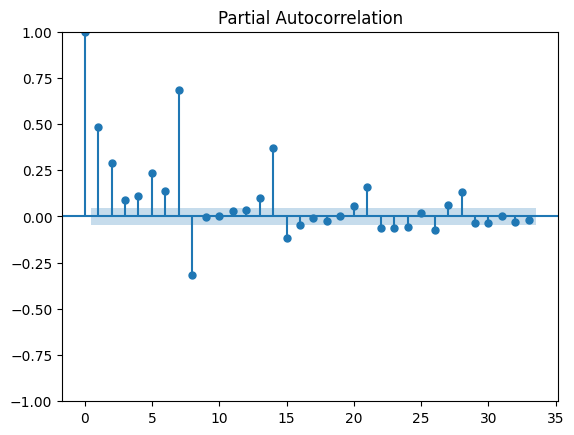

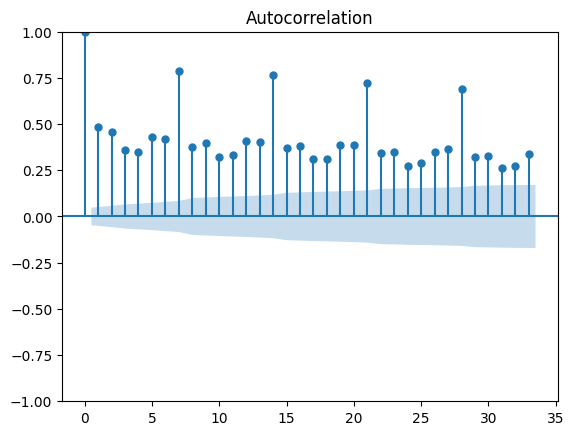

In [3]:
#Autocorrelation shifts the data ahead and calculates how well it correlates with its past self.
plot_pacf(df)
plt.show()
plot_acf(df)
plt.show()
#plot shows seasonal [weekly] trend: PACF,ACF spike every 7 days.
#This is a store in South America, I think? It makes sense that the stores would get little traffic on Sundays, because they are very religious.

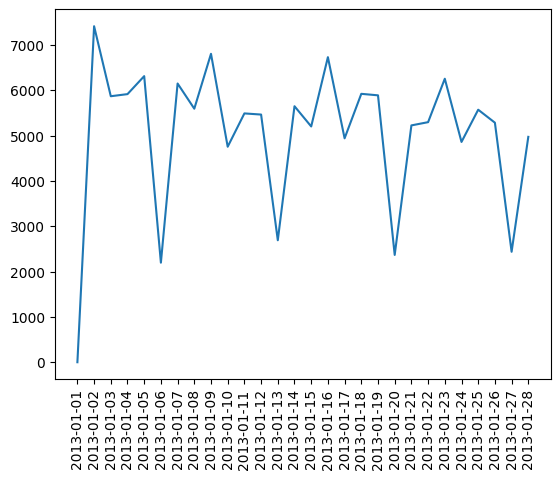

In [4]:
plt.plot(df[:28])
plt.xticks(rotation=90)
plt.show()
#With the Doomsday Algorithm, I can tell that these dips all occur on Sundays.
#Except the first one, that's a Tuesday...
#But it also makes sense that they wouldn't get a ton of traffic on New Year's Day.

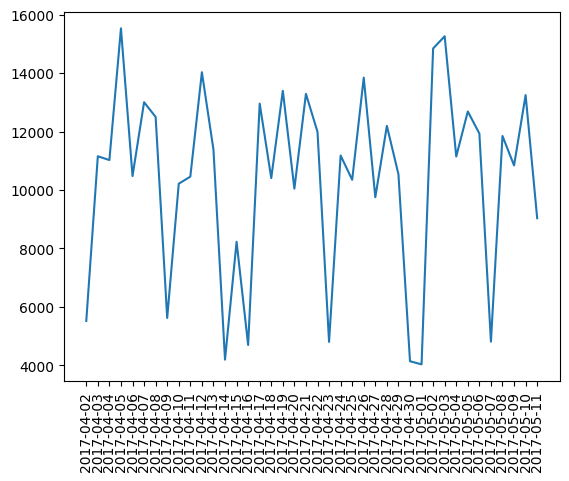

In [5]:
plt.plot(df[1348+200:1348+240]) #You'll see where 1348 comes from at the end.
plt.xticks(rotation=90)
plt.show()
#Near the end of the dataset, this Sunday trend holds up.

In [6]:
#The Augmented Dickey-Fuller test figures out whether a time-series is stationary [roughly constant].
out=adfuller(df)
print(f'p-val:{out[1]}')
#The p-value is low, meaning it's "stationary..." but we'll continue anyway.

p-val:0.03675538069904297


In [7]:
def optimize_SARIMA(params, d, D, s, data):
    #We're going to grid search over all the parameters except d, D, s.
    #d is the difference, D is the seasonal difference, and s is the seasonal parameter - which we all have easy guesses for.
    #params contains all variations of all the other parameters.
    results = []
    
    for param in params:
        try: 
            #fit each model to the data
            model=SARIMAX(
                data,
                order=(param[0],d,param[1]),
                seasonal_order=(param[2], D, param[3], s)
            ).fit(disp=-1)
            results.append([param, model.aic])
        except:
            continue
    
    out= pd.DataFrame(results)
    out.columns = ['p,q,P,Q', 'AIC']
    #It's like golf, lower scores are better.
    out=out.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return out



In [8]:
#Now we will use grid search to train the global and seasonal variables. We know the seasonal parameter is 7 periods [1 week].
p=range(0, 4, 1)
d=1
q=range(0, 4, 1)
P=range(0, 4, 1)
D=1
Q=range(0, 4, 1)
s=7
#itertools.product helps with grid search. It's a set product.
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))
#out = optimize_SARIMA(parameters_list, 1, 1, 7, train)
#out
#I made the mistake of refreshing the cell after 30 minutes of grid search.
#The best model is below.

256


In [9]:
best=SARIMAX(train,order=(1,1,2),seasonal_order=(2,1,1,7)).fit(disp=-1)
print(best.summary())


/home/user/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/user/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                         total_sales   No. Observations:                 1348
Model:             SARIMAX(1, 1, 2)x(2, 1, [1], 7)   Log Likelihood              -11781.782
Date:                             Mon, 10 Apr 2023   AIC                          23577.563
Time:                                     23:42:13   BIC                          23613.966
Sample:                                          0   HQIC                         23591.201
                                            - 1348                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7373      0.026     28.270      0.000       0.686       0.788
ma.L1         -1.3547      

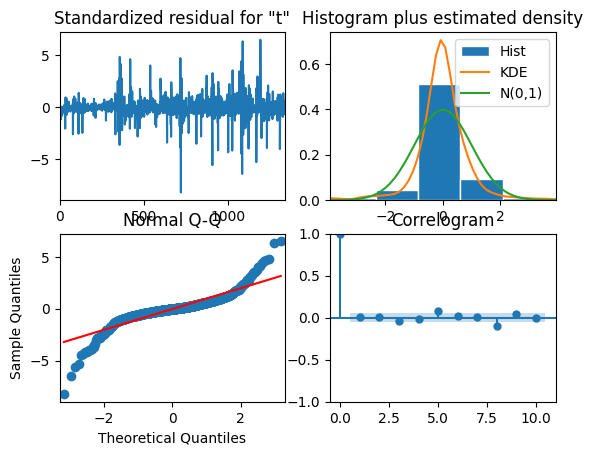

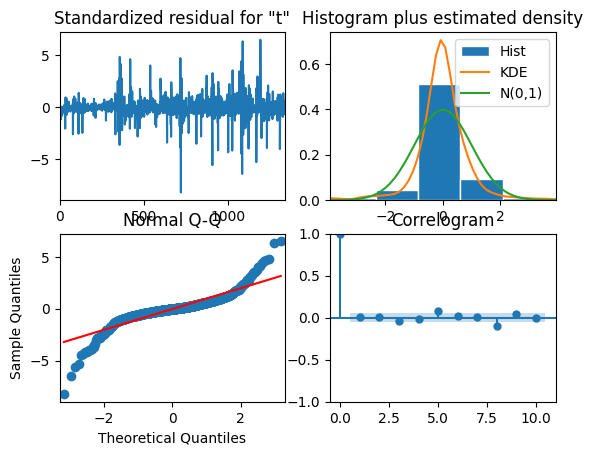

In [10]:
best.plot_diagnostics()
#As you can see, the residuals have very thin tails compared to the normal distribution.
#I'm not sure what the opposite of "kurtosed" is.

/home/user/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


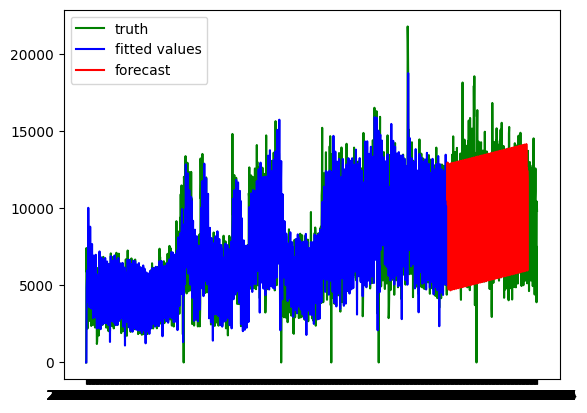

In [11]:
vals=best.fittedvalues
forecast = best.predict(start=train.shape[0], end=train.shape[0] + 300)
plt.figure()
plt.plot(df, color='g', label='truth')
plt.plot(vals, color='b', label='fitted values')
plt.plot(forecast, color='r', label='forecast')

plt.legend()
plt.show()

#...
#Well, it fits the training data very well, but clearly shows a pattern that doesn't fit the testing data.
#But, the testing data mostly overlaps with the forecast, so maybe this is the best we're usually supposed to get.
#Let's zoom in on a couple weeks in the testing set.

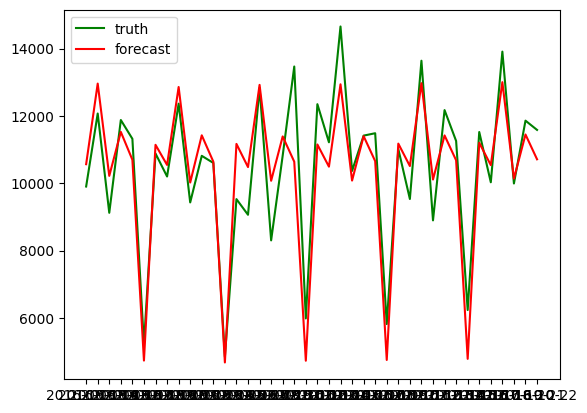

In [12]:
plt.figure()
forecasting_start_index=1348 #the index of the first forecasted date in df
start=0 #time after the start of forecasting to start plotting
end=40 #when to stop plotting
plt.plot(df[forecasting_start_index+start:forecasting_start_index+end], color='g', label='truth')
plt.plot(list(forecast)[start:end], color='r', label='forecast')

plt.legend()
plt.show()

#For the first stretch of forecasting...
#The forecast fits the truth very well!

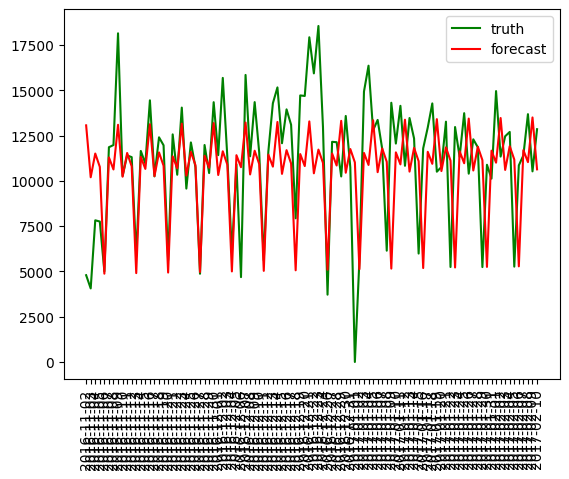

In [13]:
plt.figure()
forecasting_start_index=1348 #the index of the first forecasted date in df
start=50 #time after the start of forecasting to start plotting
end=150 #when to stop plotting
plt.plot(df[forecasting_start_index+start:forecasting_start_index+end], color='g', label='truth')
plt.plot(list(forecast)[start:end], color='r', label='forecast')
plt.xticks(rotation=90)
plt.legend()
plt.show()

#Later on, it doesn't fit so well.
#After a huge dip, the forecast gets thrown off by a day!
#Maybe it's because the dip lasted two days.